<a href="https://colab.research.google.com/github/2yujeong/NLP_Contest/blob/main/NLP_contest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 44.1MB/s 
     |████████████████████████████████| 3.8MB 48.8MB/s 
     |████████████████████████████████| 92kB 7.3MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [ ]:
import pandas as pd

# 학습 데이터 불러오기
file1 = pd.read_csv('/gdrive/My Drive/공모전_국어정보처리/daum_movie_reviews.csv')
file2 = pd.read_csv('/gdrive/My Drive/공모전_국어정보처리/naver_reviews.csv')
file3 = pd.read_csv('/gdrive/My Drive/공모전_국어정보처리/ratings.txt', delimiter = '\t')

del file3['id']

In [ ]:
# missing values 제거
file1 = file1.dropna()
file1.info()
file2 = file2.dropna()
file2.info()
file3 = file3.dropna()
file3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637 entries, 0 to 636
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  637 non-null    object
 1   Label   637 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  300 non-null    object
 1   Label   300 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 199992 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   document  199992 non-null  object
 1   label     199992 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


In [ ]:
# 추가 데이터 샘플링
f1 = file3.iloc[:2000,:]
f2 = file3.iloc[180000:182000,:]
file3 = pd.concat([f1, f2])
file3.index = pd.RangeIndex(start=1, stop=len(file3) + 1, step=1)
file3

,document,label
1,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
2,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
3,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
4,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
5,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...
3996,내용이 너무진부해서 참고보기힘들었다.. 그냥 CF감독이 만든영화같다. 한마디로 아무...,0
3997,어설프게 한국말 할바엔 그냥 하지말긔,0
3998,열라 황당하네,0
3999,첨으로 중간에 나온 영화,0


In [ ]:
import konlpy 
from konlpy.tag import Okt
import keras
from keras.preprocessing.sequence import pad_sequences

okt = Okt()

newdata = [] # 리뷰, 댓글을 저장하는 리스트
newlabel = [] # 각 data instance의 label을 저장하는 리스트

for reviews, labels in zip(file1.loc[:,'Review'], file1.loc[:,'Label']): 
  if len(okt.nouns(reviews)) != 0: # okt.nouns() : 문장을 분해하여 명사만 추출
    temp = [word for word in okt.nouns(reviews) if len(word) >= 2] # 두 글자 이상인 단어만 리스트에 추가
    newlabel.append(labels)
    newdata.append(temp)

for reviews, labels in zip(file2.loc[:,'Review'], file2.loc[:,'Label']):
  if len(okt.nouns(reviews)) != 0:
    temp = [word for word in okt.nouns(reviews) if len(word) >= 2] 
    newlabel.append(labels)
    newdata.append(temp)

for reviews, labels in zip(file3.loc[:,'document'], file3.loc[:,'label']):
  if len(okt.nouns(reviews)) != 0:
    temp = [word for word in okt.nouns(reviews) if len(word) >= 2]
    newlabel.append(labels)
    newdata.append(temp)

In [ ]:
# 비어있는 행 삭제
for words, labels in zip(newdata, newlabel): 
  if len(words) == 0:
    newdata.remove(words)
    newlabel.remove(labels)

In [ ]:
# 정수 인코딩
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer() # (num_words = n) : 빈도수 높은 n + 1개의 단어만 사용
tokenizer.fit_on_texts(newdata) # 각 단어 별로 빈도수에 따른 index가 부여된 단어 집합을 생성(단어 빈도수가 높을 수록 낮은 정수 index 부여)
newdata = tokenizer.texts_to_sequences(newdata) # 입력으로 들어온 리스트에 대해서 각 단어를 이미 정해진 index로 변환

In [ ]:
print(max(len(l) for l in newdata)) # 최대 단어 개수
print(sum(map(len, newdata)) / len(newdata)) # 평균 단어 개수

69
5.360858257477243


In [ ]:
data = pad_sequences(newdata, maxlen=15, truncating = 'post', padding='post', value = -1) # 데이터의 길이를 맞추기 위해 사용(col의 개수를 maxlen개로 지정)
# value, padding : padding value(Nan값을 채우는 값)를 -1로 지정하고 각 시퀀스의 뒤쪽(post)으로 padding
# truncation : post면 시퀀스의 뒷부분을 자르고 pre면 시퀀스의 앞부분을 자름

In [ ]:
# 각 리뷰, 댓글에 labeling
df1 = pd.DataFrame(data)
df2 = pd.DataFrame(newlabel)
df2.columns = ['label']

df = pd.concat([df1,df2], axis=1)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
0,667,1,73,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
1,1,803,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2,343,291,36,2318,2319,380,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
3,4,30,49,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
4,20,250,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4609,16,283,47,13,10,1,167,16,-1,-1,-1,-1,-1,-1,-1,0
4610,1592,13,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
4611,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
4612,101,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0


In [ ]:
# train_test_split
from sklearn.model_selection import train_test_split

# 입력 변수와 정답 셋(label)으로 나누기
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]

# train set과 test set 나누기
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2048      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1

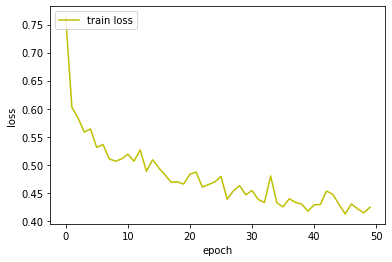

29/29 [==============================] - 0s 2ms/step - loss: 0.7019 - accuracy: 0.6457
0.6457204818725586


In [ ]:
from keras import models
from keras import layers
from keras.layers import BatchNormalization
from keras.layers import Dropout

model = models.Sequential()
model.add(layers.Dense(units = 128, input_dim = 15, kernel_initializer='he_normal', activation = 'relu'))
model.add(BatchNormalization()) # Normalization
model.add(layers.Dense(units = 256, kernel_initializer='he_normal', activation = 'relu')) # 가중치 초기화
model.add(BatchNormalization())
model.add(layers.Dense(units = 512, kernel_initializer='he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.Dense(units = 256, kernel_initializer='he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.Dense(units = 128, kernel_initializer='he_normal', activation = 'relu',))
model.add(layers.Dense(2, activation = 'softmax'))

model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, Y_train, epochs=50, batch_size=128) 

# 트레이닝 Epoch에 따른 Loss의 변화를 그래프로 시각화
%matplotlib inline
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
plt.show()

test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=1)
print(test_acc)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

gbc = GradientBoostingClassifier()
gbc.fit(X_train, Y_train)
score = cross_val_score(gbc, X_train, Y_train, scoring='accuracy')
score = np.mean(score)
score

0.7339468482641524

# --- TEST CODE ---

In [ ]:
test = pd.read_csv('/gdrive/My Drive/test.csv') 

test_data = []
for review in test['document']:
  temp = [word for word in okt.nouns(review) if len(word) >= 2]
  test_data.append(temp)

test_data = tokenizer.texts_to_sequences(test_data)
test_data = pad_sequences(test_data, maxlen=15, 
                          truncating = 'post', padding='post', value = 0)

pred = gbc.predict(test_data)

result = pd.DataFrame({
    "document" : test["document"],
    "label" : pred
})

result.to_csv('/gdrive/My Drive/result.csv', index=False)

,document,label
3071,잔잔한 스토리 기억에 남을 영상과 음악,1
3072,볼만한데요 감동도잇구,1
3073,명탐정 코난 극장판:은빛날개의 마술사,1
3074,너무 좋았던영화다..여운도 많이 남고. 되게 동감되고 ㅠ_ㅠ,1
3075,1.11 시사회보고나서:),0
3076,넘넘 감동적이에요.....ㅠ.ㅠ,1
151059,미국코미디는 정말 나하곤 안맞는갑다.보는내내 유치하고 지루하고..,0
151060,된장,0
151061,여자비명소리 정말 거슬림..,0
151062,편하게 보기 좋아,0


In [ ]:
test = pd.read_csv('/gdrive/My Drive/공모전_국어정보처리/ratings.txt', delimiter = '\t')
test1 = test.iloc[3071:3077,:]
test2 = test.iloc[151059:151064,:]
test3 = pd.concat([test1, test2])
del test3['id']
del test3['label']
test3

,document
3071,잔잔한 스토리 기억에 남을 영상과 음악
3072,볼만한데요 감동도잇구
3073,명탐정 코난 극장판:은빛날개의 마술사
3074,너무 좋았던영화다..여운도 많이 남고. 되게 동감되고 ㅠ_ㅠ
3075,1.11 시사회보고나서:)
3076,넘넘 감동적이에요.....ㅠ.ㅠ
151059,미국코미디는 정말 나하곤 안맞는갑다.보는내내 유치하고 지루하고..
151060,된장
151061,여자비명소리 정말 거슬림..
151062,편하게 보기 좋아
